# MS4610 Introduction to Data Analytics || Course Project 
### Model Selection and Hyperparameter Tuning
Notebook by **Group 12**

Using cleaned data, this notebook attempts to find the model that best predicts chances of payment default. We look at model performances without any feature engineering (baseline) and the same when sufficient feature engineering has been performed. The following operations have been performed:

1. Baseline performance using gradient boosted models. 

In [46]:
# Data and image handling libraries

import numpy as np
import pandas as pd
from glob import glob
import cv2

# Classifiers

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

# Data preprocessing functions

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Evaluation metrics

from sklearn.metrics import roc_auc_score 
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

# Plotting libraries

import matplotlib.pyplot as plt

# Others

import statistics as stats
from scipy.stats import boxcox
from IPython.display import clear_output
from warnings import filterwarnings
filterwarnings('ignore')

In [66]:
# Import dataset

train = pd.read_csv(".././mod_data/train.csv")
train[['card_type', 'location_id']].astype('int', inplace=True) 
train['predictable_due_factor'] = (train['max_credit_act_rev']-train['min_credit_rev'])*train['stress_index']

train_zero = pd.read_csv("/home/nishant/Desktop/IDA Project/mod_data/train_zero.csv")
train_mf = pd.read_csv("/home/nishant/Desktop/IDA Project/mod_data/train_mf.csv")
train_mf_res = pd.read_csv("/home/nishant/Desktop/IDA Project/mod_data/train_mf_res.csv")
train_final = pd.read_csv("/home/nishant/Desktop/IDA Project/mod_data/train_final.csv")
test_final = pd.read_csv("/home/nishant/Desktop/IDA Project/mod_data/test_final.csv")
train_bin = pd.read_csv("/home/nishant/Desktop/IDA Project/mod_data/train_bin.csv")

# Randomly resampled data

train_os = pd.read_csv(".././rs_data/train_os.csv")
train_us = pd.read_csv(".././rs_data/train_us.csv")
test_rs = pd.read_csv(".././rs_data/test_rs.csv")

cat_cols = ['card_type', 'location_id']
for df in [train_os, train_us, test_rs]:
    df[cat_cols] = df[cat_cols].astype('int')
    
# Randomly resampled data with chi-square pruning

train_os_chi2 = pd.read_csv(".././rs_data/train_os_chi2.csv")
train_us_chi2 = pd.read_csv(".././rs_data/train_us_chi2.csv")
test_rs_chi2 = pd.read_csv(".././rs_data/test_rs_chi2.csv")

cat_cols = ['location_id']
for df in [train_os_chi2, train_us_chi2, test_rs_chi2]:
    df[cat_cols] = df[cat_cols].astype('int')

## Useful Functions
The functions below will be used to track the model's performance, which will assist us in hyperparameter tuning. The following functions are available:
1. **learn_progress**: Plots trends of training and cross-validation score against %age data learned

In [3]:
def learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2):
    """
    Plots learning curves for training and cross-validation for input model and dataset
    as a function of fraction of data the model has trained on.
    
    :param model: (scikit-learn model-like) The model which is being trained on the data
    :param X: (numpy array-like) Training features
    :param y: (numpy array-like) Target values for prediction
    :param res: (integer) Number of points on which progress is calculated (default = 5)
    :param scoring: (scikit-learn SCORER string) Parameter indicating learning progress.
                    Scorer options can be accessed using sklearn.metrics.SCORERS.keys()
                    (default = 'roc_auc')
    :param cv: Number of cross-validation folds (default = 2)
    
    :return:
        Renders a matplotlib pyplot object of with line plots of training and validation 
        scores.
    """
    train_sizes = np.linspace(0.1, 1, res)
    _, train_scores, valid_scores = learning_curve(model, X, y, train_sizes=train_sizes,
                                                   scoring=scoring, cv=cv)
    
    fig, ax = plt.subplots()
    plt.grid()
    
    plt.plot(train_scores.mean(axis=1), marker='o', c='blue', alpha=0.7)
    plt.plot(valid_scores.mean(axis=1), marker='o', c='red', alpha=0.7)
    
    plt.title('Learning progress')
    plt.ylabel('Score')
    plt.xlabel('Progress')
    plt.xticks([i for i in range(res)], np.linspace(0.1, 1, res))
    plt.legend(['Training score', 'Validation score'])

    plt.show()
    
    print("Training CV score: {:.4f}".format(np.mean(train_scores[-1, :])))
    print("Validation CV score: {:.4f}".format(np.mean(valid_scores[-1, :])))
    
    
# FUNCTION TO CHECK PERFORMANCE AGAINST MODEL COMPLEXITY
# NON-CALLABLE FUNCTION, COPY FUNCTION BODY WHEREVER NEEDED, MODIFY AND USE

# train_scores = []
# test_scores = []

# for i in range(7):
    
#     # Model definition and training
#     model = LGBMClassifier(n_estimators=100,
#                            max_depth=i+1,
#                            learning_rate=0.01, 
#                            objective='binary',
#                            metric='auc',
#                            lambda_l2=10.0,
#                            random_state=123)

#     model.fit(X_train, y_train)

#     # Prediction
#     preds_train = model.predict(X_train)
#     preds_test = model.predict(X_test)

#     # Scoring
#     train_scores.append(roc_auc_score(y_train, preds_train))
#     test_scores.append(roc_auc_score(y_test, preds_test))
    
# # Plot training and test score
# plt.figure(figsize=(7, 5))
# plt.title('Score vs. complexity')
# plt.plot(np.linspace(1, 7, 7), train_scores, marker='o', linestyle='-', c='blue', alpha=0.7)
# plt.plot(np.linspace(1, 7, 7), test_scores, marker='o', linestyle='-', c='red', alpha=0.7)
# plt.legend(['Train score', 'Test score'])
# plt.xlabel('Max Depth')
# plt.ylabel('AUC Score')
# plt.grid()
# plt.show()

In [4]:
# Deskew data using boxcox

skew_cols = []
for col in train.drop(['application_key', 'default_ind', 'card_type', 'location_id'], axis=1).columns:
    if abs(train[col].skew()) >= 1:
        skew_cols.append(col)
        
# Making sure all data is positive
train[skew_cols] = train[skew_cols].apply(lambda x: x + np.random.rand())
train[skew_cols] = train[skew_cols].apply(lambda x: x + 1)
        
for col in skew_cols:
    train[col] = train[col].apply(np.log)

In [5]:
train.skew()

application_key          1.599701
credit_score             0.102214
risk_score               1.464976
sev_def_any              0.915914
sev_def_auto             3.468293
sev_def_edu              4.011475
min_credit_rev          -0.603725
max_credit_act          -1.568682
max_credit_act_rev      -1.152154
total_credit_1_miss     -0.935509
total_credit            -1.257270
due_collected           -0.289084
total_due               -1.458371
annual_pay              -1.058849
annual_income           -4.331143
property_value          -0.438744
fc_cards_act_rev         2.642096
fc_cards_act             2.695276
fc_lines_act             2.349254
pc_cards_act             1.440189
pc_lines_act             1.240874
loan_util_act_rev       -1.250923
line_util_past2         -1.412220
line_util_past1         -1.284983
line_util_1_miss        -0.433225
tenure_act_rev          -1.275731
tenure_oldest_act       -1.230232
tenure_oldest_act_rev   -1.223196
last_miss_time           0.961186
tenure_oldest_

## Baseline Model Performance
In this section, we check the performance of **gradient boosted decision-tree models** on the dataset without any feature engineering or hyperparameter tuning. This will provide a benchmark to improve upon as we modify/generate/discard features from the dataset. The models below were chosen as they can internally handle missing values. The following models have been tested.
1. XGBoost Classifier
2. LightGBM Classifier

In [50]:
# XGBoost Classifier

# Features and target are defined
y = train.default_ind.values
X = train.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definiton and training
model = XGBClassifier(n_estimators=300,
                      max_depth=9,
                      learning_rate=0.05,
                      objective='binary:logistic',
                      subsample=0.5,
                      colsample_bytree=0.5,
                      scale_pos_weight=2.20,
                      random_state=123)

# model.fit(X_train, y_train)

# Prediction
# preds = model.predict(X_val)

# Scoring
scores = ['roc_auc', 'accuracy', 'balanced_accuracy', 'f1']
score_dict = cross_validate(model, X, y, cv=3, scoring=scores)

train_scores = np.array([np.mean(score_dict['train_roc_auc']), np.mean(score_dict['train_accuracy']), 
                np.mean(score_dict['train_balanced_accuracy']), np.mean(score_dict['train_f1'])])
test_scores = np.array([np.mean(score_dict['test_roc_auc']), np.mean(score_dict['test_accuracy']), 
               np.mean(score_dict['test_balanced_accuracy']), np.mean(score_dict['test_f1'])])
perf_table = pd.DataFrame(np.vstack((np.array(scores), train_scores, test_scores)).T, columns=['Metric', 'Train', 'Test'])
               
print(perf_table)
print('')
# print(classification_report(y_val, preds))

# Show learning progress
# learn_progress(model, X, y, res=5, scoring='accuracy', cv=2)

              Metric               Train                Test
0            roc_auc  0.8393846218684597  0.7897869199396107
1           accuracy   0.771186756225172  0.7383493517887788
2  balanced_accuracy  0.7535323280366367  0.7135833211787176
3                 f1  0.6414101635913275  0.5900760724487789

              precision    recall  f1-score   support

         0.0       0.85      0.78      0.81     11829
         1.0       0.54      0.65      0.59      4771

   micro avg       0.74      0.74      0.74     16600
   macro avg       0.69      0.71      0.70     16600
weighted avg       0.76      0.74      0.75     16600



In [56]:
# LightGBM Classifier

# Features and target are defined
y = train.default_ind.values
X = train.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = LGBMClassifier(n_estimators=500,
                       max_depth=9,
                       learning_rate=0.05, 
                       objective='binary',
                       subsample=0.5,
                       colsample_bytree=0.5,
                       scale_pos_weight=2.20,
                       random_state=123,
                       n_jobs=-1)

# model.fit(X_train, y_train)

# Prediction
# preds = model.predict(X_val)

# Scoring
scores = ['roc_auc', 'accuracy', 'balanced_accuracy', 'f1']
score_dict = cross_validate(model, X, y, cv=5, scoring=scores)

train_scores = np.array([np.mean(score_dict['train_roc_auc']), np.mean(score_dict['train_accuracy']), 
                         np.mean(score_dict['train_balanced_accuracy']), np.mean(score_dict['train_f1'])])
test_scores = np.array([np.mean(score_dict['test_roc_auc']), np.mean(score_dict['test_accuracy']), 
               np.mean(score_dict['test_balanced_accuracy']), np.mean(score_dict['test_f1'])])
perf_table = pd.DataFrame(np.vstack((np.array(scores), train_scores, test_scores)).T, columns=['Metric', 'Train', 'Test'])
               
print(perf_table)
print('')
# print(classification_report(y_val, preds))


# Show learning progress
# learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

              Metric               Train                Test
0            roc_auc  0.8722631915603966  0.7905890406184446
1           accuracy  0.7991204819277109  0.7425180722891567
2  balanced_accuracy  0.7832655505488955  0.7133315734687047
3                 f1  0.6809822792636424  0.5899641379861155



In [86]:
# CatBoost Classifier

int_cols = ['card_type', 'location_id']
train[int_cols] = train[int_cols].astype('int')

# Features and target are defined
y = train.default_ind
X = train.drop(['application_key', 'default_ind'], axis=1)

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
cat_idx = np.where(X_train.dtypes != float)[0]

# Model definition and training
model = CatBoostClassifier(iterations=300,
                           depth=9,
                           learning_rate=0.05,
                           cat_features=cat_idx,
                           eval_metric='BalancedAccuracy',
                           random_state=123,
                           verbose=0)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
auc_score = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
acc_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
bal_acc_score = cross_val_score(model, X, y, cv=5, scoring='balanced_accuracy')
f_score = cross_val_score(model, X, y, cv=5, scoring='f1')
print("ROC-AUC Score (no CV): {}".format(np.mean(auc_score)))
print("Accuracy Score (no CV): {}".format(np.mean(acc_score)))
print("Balanced Accuracy Score (no CV): {}".format(np.mean(bal_acc_score)))
print("F1 Score: {}".format(np.mean(f_score)))
print('')
print(classification_report(y_val, preds))


# Show learning progress
# learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

ROC-AUC Score (no CV): 0.793044425649
Accuracy Score (no CV): 0.774710843373
Balanced Accuracy Score (no CV): 0.669750000173
F1 Score: 0.518644992184

              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85     11829
         1.0       0.66      0.43      0.52      4771

   micro avg       0.77      0.77      0.77     16600
   macro avg       0.73      0.67      0.68     16600
weighted avg       0.76      0.77      0.76     16600



In [19]:
# AdaBoost Classifier
train_ada = train.fillna(0)

# Features and target are defined
y = train_ada.default_ind.values
X = train_ada.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = AdaBoostClassifier(n_estimators=300, random_state=123)
model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
scores = ['roc_auc', 'accuracy', 'balanced_accuracy', 'f1']
score_dict = cross_validate(model, X, y, cv=5, scoring=scores)

train_scores = np.array([np.mean(score_dict['train_roc_auc']), np.mean(score_dict['train_accuracy']), 
                         np.mean(score_dict['train_balanced_accuracy']), np.mean(score_dict['train_f1'])])
test_scores = np.array([np.mean(score_dict['test_roc_auc']), np.mean(score_dict['test_accuracy']), 
               np.mean(score_dict['test_balanced_accuracy']), np.mean(score_dict['test_f1'])])
perf_table = pd.DataFrame(np.vstack((np.array(scores), train_scores, test_scores)).T, columns=['Metric', 'Train', 'Test'])
               
print(perf_table)
print('')
print(classification_report(y_val, preds))


# Show learning progress
# learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

              Metric               Train                Test
0            roc_auc  0.7957495211536278  0.7849656086623471
1           accuracy  0.7745180722891567  0.7686144578313254
2  balanced_accuracy  0.6698117114951072  0.6627460330884671
3                 f1  0.5191677871506749  0.5065380777114901

              precision    recall  f1-score   support

         0.0       0.79      0.91      0.85     11829
         1.0       0.65      0.41      0.51      4771

   micro avg       0.77      0.77      0.77     16600
   macro avg       0.72      0.66      0.68     16600
weighted avg       0.75      0.77      0.75     16600



In [59]:
# Naive Bayes Classifier
train_nb = train
for col in train.columns:
    train_nb[col] = train[col].fillna(train[col].mean())

# Features and target are defined
y = train_nb.default_ind.values
X = train_nb.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = RandomForestClassifier(n_estimators=50, max_depth=9, random_state=123)
model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
scores = ['roc_auc', 'accuracy', 'balanced_accuracy', 'f1']
score_dict = cross_validate(model, X, y, cv=5, scoring=scores)

train_scores = np.array([np.mean(score_dict['train_roc_auc']), np.mean(score_dict['train_accuracy']), 
                         np.mean(score_dict['train_balanced_accuracy']), np.mean(score_dict['train_f1'])])
test_scores = np.array([np.mean(score_dict['test_roc_auc']), np.mean(score_dict['test_accuracy']), 
               np.mean(score_dict['test_balanced_accuracy']), np.mean(score_dict['test_f1'])])
perf_table = pd.DataFrame(np.vstack((np.array(scores), train_scores, test_scores)).T, columns=['Metric', 'Train', 'Test'])
               
print(perf_table)
print('')
print(classification_report(y_val, preds))


# Show learning progress
# learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

              Metric               Train                 Test
0            roc_auc  0.8233374721249191   0.7816455262307983
1           accuracy  0.7913584337349399   0.7687710843373494
2  balanced_accuracy  0.6768193894095451   0.6481987053725609
3                 f1  0.5288492683062941  0.47522594590422196

              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85     11829
         1.0       0.68      0.37      0.47      4771

   micro avg       0.77      0.77      0.77     16600
   macro avg       0.73      0.65      0.66     16600
weighted avg       0.75      0.77      0.74     16600



In [73]:
# =========================  PHASE 1 SUBMISSION MODEL  ==================================== #

# Voting Classifier with XGBoost and LightGBM
    
# Features and target are defined
y = train.default_ind
X = train.drop(['application_key', 'default_ind'], axis=1)
# cat_idx = np.where(X.dtypes != float)[0]

# Aggregate estimators
estimators = []

model_1 = XGBClassifier(n_estimators=300,
                      max_depth=9,
                      learning_rate=0.05,
                      objective='binary:logistic',
                      subsample=0.5,
                      colsample_bytree=0.5,
                      scale_pos_weight=2.20,
                      random_state=123)
estimators.append(('xgb', model_1))

model_2 = LGBMClassifier(n_estimators=500,
                       max_depth=9,
                       learning_rate=0.05, 
                       objective='binary',
                       subsample=0.5,
                       colsample_bytree=0.5,
                       scale_pos_weight=2.20,
                       random_state=123)
estimators.append(('lgb', model_2))

# Voting Classifier
clf = VotingClassifier(estimators, voting='soft')
print('[INFO] Model Initialized')

# Scoring
scores = ['roc_auc', 'accuracy', 'balanced_accuracy', 'f1']
print('[INFO] Scoring started')
score_dict = cross_validate(clf, X, y, cv=5, scoring=scores)

train_scores = np.array([np.mean(score_dict['train_roc_auc']), np.mean(score_dict['train_accuracy']), 
                         np.mean(score_dict['train_balanced_accuracy']), np.mean(score_dict['train_f1'])])
test_scores = np.array([np.mean(score_dict['test_roc_auc']), np.mean(score_dict['test_accuracy']), 
               np.mean(score_dict['test_balanced_accuracy']), np.mean(score_dict['test_f1'])])
perf_table = pd.DataFrame(np.vstack((np.array(scores), train_scores, test_scores)).T, columns=['Metric', 'Train', 'Test'])
               
print(perf_table)

[INFO] Model Initialized
[INFO] Scoring started
              Metric               Train                Test
0            roc_auc  0.9279635769507276  0.7912107430982325
1           accuracy   0.852421686746988               0.749
2  balanced_accuracy  0.8414253980324918  0.7120893627789233
3                 f1  0.7605747757989765  0.5887244428266297


In [77]:
# Import and predict on test data

test_final = pd.read_csv(".././mod_data/test_final.csv")
X_test = test_final.drop(['application_key'], axis=1)
X_test['predictable_due_factor'] = (X_test['max_credit_act_rev']-X_test['min_credit_rev'])*X_test['stress_index'] 
X_test[['card_type', 'location_id']] = X_test[['card_type', 'location_id']].astype('int')

clf.fit(X, y)
test_preds = clf.predict(X_test)
test_preds

array([0., 0., 0., ..., 1., 0., 0.])

In [78]:
app_keys = test_final['application_key'].astype('int').values
test_preds = test_preds.astype('int')
sub_vals = np.vstack((app_keys, test_preds)).T
sub_df = pd.DataFrame(sub_vals, columns=['application_key', 'default_ind'])
sub_df.to_csv(".././submission/Group_12_submission.csv", index=False)

### On zero imputed datasets
After imputation of datasets in `DataCleaning.ipynb` we will test the models above and see if any changes in performance are observed.

ROC-AUC Score (no CV): 0.7150680148689939

              precision    recall  f1-score   support

         0.0       0.86      0.73      0.79     11805
         1.0       0.51      0.70      0.59      4759

    accuracy                           0.72     16564
   macro avg       0.68      0.72      0.69     16564
weighted avg       0.76      0.72      0.73     16564



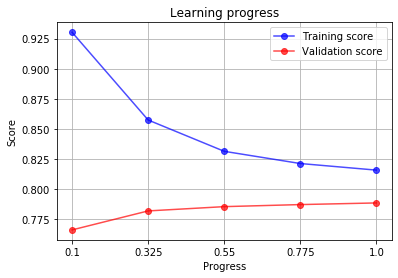

In [6]:
# XGBoost Classifier

# Label Encoder
encode_cols = ['card_type']
le = LabelEncoder()
train[encode_cols] = le.fit_transform(train[encode_cols])

# Features and target are defined
y = train.default_ind.values
X = train.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definiton and training
model = XGBClassifier(n_estimators=200,
                      max_depth=4,
                      learning_rate=0.05,
                      objective='binary:logistic',
                      scale_pos_weight=2.4794,
                      random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
auc_score = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
acc_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
bal_acc_score = cross_val_score(model, X, y, cv=5, scoring='balanced_accuracy')
f_score = cross_val_score(model, X, y, cv=5, scoring='f1')
print("ROC-AUC Score (no CV): {}".format(np.mean(auc_score)))
print("Accuracy Score (no CV): {}".format(np.mean(acc_score)))
print("Balanced Accuracy Score (no CV): {}".format(np.mean(bal_acc_score)))
print("F1 Score: {}".format(np.mean(f_score)))
print('')
print(classification_report(y_val, preds))

# Show learning progress
# learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2)

In [57]:
# LightGBM Classifier

# Label Encoder
encode_cols = ['card_type']
le = LabelEncoder()
train_zero[encode_cols] = le.fit_transform(train_zero[encode_cols])

# Features and target are defined
y = train_zero.default_ind.values
X = train_zero.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = LGBMClassifier(n_estimators=300,
                       max_depth=5,
                       learning_rate=0.05, 
                       objective='binary',
                       scale_pos_weight=2.20,
                       random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
auc_score = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
acc_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
bal_acc_score = cross_val_score(model, X, y, cv=5, scoring='balanced_accuracy')
f_score = cross_val_score(model, X, y, cv=5, scoring='f1')
print("ROC-AUC Score (no CV): {}".format(np.mean(auc_score)))
print("Accuracy Score (no CV): {}".format(np.mean(acc_score)))
print("Balanced Accuracy Score (no CV): {}".format(np.mean(bal_acc_score)))
print("F1 Score: {}".format(np.mean(f_score)))
print('')
print(classification_report(y_val, preds))


# Show learning progress
# learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

ROC-AUC Score (no CV): 0.791533242012
Accuracy Score (no CV): 0.738638554217
Balanced Accuracy Score (no CV): 0.715124175974
F1 Score: 0.592008286738

              precision    recall  f1-score   support

           0       0.85      0.77      0.81     11829
           1       0.54      0.66      0.59      4771

   micro avg       0.74      0.74      0.74     16600
   macro avg       0.69      0.72      0.70     16600
weighted avg       0.76      0.74      0.75     16600



## On mean imputed dataset
Models on mean imputed dataset.

In [61]:
# LightGBM Classifier

# Mean imputation
for col in train.columns:
    train[col].fillna(np.median(train[col]), inplace=True)

# Features and target are defined
y = train.default_ind.values
X = train.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = LGBMClassifier(n_estimators=300,
                       max_depth=9,
                       learning_rate=0.05, 
                       objective='binary',
                       scale_pos_weight=2.20,
                       random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
auc_score = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
acc_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
bal_acc_score = cross_val_score(model, X, y, cv=5, scoring='balanced_accuracy')
f_score = cross_val_score(model, X, y, cv=5, scoring='f1')
print("ROC-AUC Score (no CV): {}".format(np.mean(auc_score)))
print("Accuracy Score (no CV): {}".format(np.mean(acc_score)))
print("Balanced Accuracy Score (no CV): {}".format(np.mean(bal_acc_score)))
print("F1 Score: {}".format(np.mean(f_score)))
print('')
print(classification_report(y_val, preds))


# Show learning progress
# learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

ROC-AUC Score (no CV): 0.790326740698
Accuracy Score (no CV): 0.740168674699
Balanced Accuracy Score (no CV): 0.714809624092
F1 Score: 0.591655923556

              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81     11829
         1.0       0.54      0.65      0.59      4771

   micro avg       0.74      0.74      0.74     16600
   macro avg       0.69      0.71      0.70     16600
weighted avg       0.76      0.74      0.75     16600



In [63]:
# SGD Classifier

# Mean imputation
for col in train.columns:
    train[col].fillna(np.mean(train[col]), inplace=True)

# Features and target are defined
y = train.default_ind.values
X = train.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = GradientBoostingClassifier(n_estimators=200, random_state=123)
model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
auc_score = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
acc_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
bal_acc_score = cross_val_score(model, X, y, cv=5, scoring='balanced_accuracy')
f_score = cross_val_score(model, X, y, cv=5, scoring='f1')
print("ROC-AUC Score (no CV): {}".format(np.mean(auc_score)))
print("Accuracy Score (no CV): {}".format(np.mean(acc_score)))
print("Balanced Accuracy Score (no CV): {}".format(np.mean(bal_acc_score)))
print("F1 Score: {}".format(np.mean(f_score)))
print('')
print(classification_report(y_val, preds))


# Show learning progress
# learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

ROC-AUC Score (no CV): 0.789410461119
Accuracy Score (no CV): 0.772228915663
Balanced Accuracy Score (no CV): 0.665644851911
F1 Score: 0.51125165637

              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85     11829
         1.0       0.66      0.42      0.51      4771

   micro avg       0.77      0.77      0.77     16600
   macro avg       0.73      0.67      0.68     16600
weighted avg       0.76      0.77      0.75     16600



In [73]:
# Neural network

for col in train.columns:
    train[col] = train[col].fillna(np.mean(train[col]))

# Dependencies

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.utils import to_categorical
from keras.layers.embeddings import Embedding

# Training and test split
y_df = train.default_ind
X_df = train.drop(['application_key', 'default_ind'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2)

train_nn = pd.concat([X_train, y_train], axis=1)
test_nn = pd.concat([X_test, y_test], axis=1)

# EMBEDDING FOR TRAIN LOCATION ID ============================================================================

labels = train_nn.default_ind.values

le = LabelEncoder()
train_nn['location_id'] = le.fit_transform(train_nn.location_id)
test_nn['location_id'] = le.fit_transform(test_nn.location_id)

vocab_size = train_nn.location_id.nunique()
max_length = 1
embed_vec_size = 33
loc_id_train = train_nn.location_id.values
loc_id_test = test_nn.location_id.values

# Define model
print('[INFO] Generating embeddings')
model = Sequential()
model.add(Embedding(vocab_size, embed_vec_size, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(loc_id_train, labels, epochs=5, batch_size=1000)

# Get outputs of first layer
new_model = Sequential()
new_model.add(Embedding(vocab_size, embed_vec_size, input_length=max_length))

new_model.set_weights(model.layers[0].get_weights())
new_model.compile(optimizer='adam', loss='binary_crossentropy')

preds_train = new_model.predict(loc_id_train).reshape(-1, embed_vec_size)
preds_test = new_model.predict(loc_id_test).reshape(-1, embed_vec_size)
embed_col_train = ['loc_emb'+str(i) for i in range(preds_train.shape[1])]
embed_col_test = ['loc_emb'+str(i) for i in range(preds_test.shape[1])]
loc_embed_df_train = pd.DataFrame(preds_train, columns=embed_col_train)
loc_embed_df_test = pd.DataFrame(preds_test, columns=embed_col_test)

# =============================================================================================================

# Scaling numerical columns of X
ss = StandardScaler()
non_num_cols = ['card_type', 'location_id', 'default_ind']
X_sc_train = ss.fit_transform(train_nn.drop(non_num_cols, axis=1).values)
X_sc_test = ss.fit_transform(test_nn.drop(non_num_cols, axis=1).values)

X_df_train = pd.DataFrame(X_sc_train)
X_df_train['card_type'] = train_nn.card_type.values
X_df_train = pd.concat([X_df_train, loc_embed_df_train], axis=1)

X_df_test = pd.DataFrame(X_sc_test)
X_df_test['card_type'] = test_nn.card_type.values
X_df_test = pd.concat([X_df_test, loc_embed_df_test], axis=1)

# Training data
y = to_categorical(train_nn.default_ind.values)
X = X_df_train.values

rows, cols = X.shape[0], X.shape[1]

# Defining prediction model
print('')
print('[INFO] Training model')
model = Sequential()
model.add(Dense(128, input_dim=cols))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.25))
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.25))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X, y, epochs=5, batch_size=1000)

y_val = test_nn.default_ind.values
X_val = X_df_test.values

# Predictions
preds = []
probs = model.predict(X_val)
for i in probs:
    preds.append(np.argmax(i))

preds = np.array(preds).reshape((-1, 1))
y_val_preds = np.array(y_val).reshape((-1, 1))

auc_score = roc_auc_score(y_val_preds, preds)
acc_score = accuracy_score(y_val_preds, preds)
bal_acc_score = balanced_accuracy_score(y_val_preds, preds)
f_score = f1_score(y_val_preds, preds)
print('')
print("AUC Score: {:.4f}".format(auc_score))
print("Accuracy Score: {:.4f}".format(acc_score))
print("Balanced Accuracy Score: {:.4f}".format(bal_acc_score))
print("F1 Score: {:.4f}".format(f_score))
print('')
print(classification_report(y_val_preds, preds))

[INFO] Generating embeddings
Epoch 1/5
66400/66400 [==============================] - 1s 8us/step - loss: 0.6510 - binary_accuracy: 0.6950
Epoch 2/5
66400/66400 [==============================] - 0s 2us/step - loss: 0.6042 - binary_accuracy: 0.7120
Epoch 3/5
66400/66400 [==============================] - 0s 2us/step - loss: 0.5986 - binary_accuracy: 0.7120
Epoch 4/5
66400/66400 [==============================] - 0s 2us/step - loss: 0.5981 - binary_accuracy: 0.7120
Epoch 5/5
66400/66400 [==============================] - 0s 2us/step - loss: 0.5980 - binary_accuracy: 0.7120

[INFO] Training model
Epoch 1/5
66400/66400 [==============================] - 4s 58us/step - loss: 0.5331 - accuracy: 0.7474
Epoch 2/5
66400/66400 [==============================] - 3s 51us/step - loss: 0.5034 - accuracy: 0.7629
Epoch 3/5
66400/66400 [==============================] - 3s 51us/step - loss: 0.4989 - accuracy: 0.7648
Epoch 4/5
66400/66400 [==============================] - 3s 52us/step - loss: 0.4953 -

## On garbage value imputed dataset
We impute a garbage value inplace of missing values to indicate its presence.

In [64]:
# LightGBM Classifier

# Mean imputation
for col in train.columns:
    train[col].fillna(999999, inplace=True)

# Features and target are defined
y = train.default_ind.values
X = train.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = LGBMClassifier(n_estimators=300,
                       max_depth=9,
                       learning_rate=0.05, 
                       objective='binary',
                       scale_pos_weight=2.20,
                       random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
auc_score = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
acc_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
bal_acc_score = cross_val_score(model, X, y, cv=5, scoring='balanced_accuracy')
f_score = cross_val_score(model, X, y, cv=5, scoring='f1')
print("ROC-AUC Score (no CV): {}".format(np.mean(auc_score)))
print("Accuracy Score (no CV): {}".format(np.mean(acc_score)))
print("Balanced Accuracy Score (no CV): {}".format(np.mean(bal_acc_score)))
print("F1 Score: {}".format(np.mean(f_score)))
print('')
print(classification_report(y_val, preds))


# Show learning progress
# learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

ROC-AUC Score (no CV): 0.790326740698
Accuracy Score (no CV): 0.740168674699
Balanced Accuracy Score (no CV): 0.714809624092
F1 Score: 0.591655923556

              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81     11829
         1.0       0.54      0.65      0.59      4771

   micro avg       0.74      0.74      0.74     16600
   macro avg       0.69      0.71      0.70     16600
weighted avg       0.76      0.74      0.75     16600



### On missing forest imputed dataset
We expected somewhat better performance on missing forest imputed data.

ROC-AUC Score (no CV): 0.7111619764197022

              precision    recall  f1-score   support

         0.0       0.85      0.74      0.79     11753
         1.0       0.51      0.68      0.59      4740

    accuracy                           0.72     16493
   macro avg       0.68      0.71      0.69     16493
weighted avg       0.76      0.72      0.73     16493



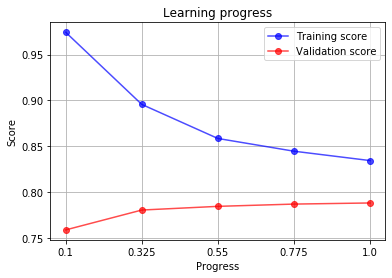

Training CV score: 0.8772
Validation CV score: 0.7817


In [11]:
# XGBoost Classifier

# Features and target are defined
y = train_mf.default_ind.values
X = train_mf.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definiton and training
model = XGBClassifier(n_estimators=300,
                      max_depth=5,
                      learning_rate=0.05,
                      objective='binary:logistic',
                      scale_pos_weight=2.4794,
                      random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
auc_score = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
acc_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
bal_acc_score = cross_val_score(model, X, y, cv=5, scoring='balanced_accuracy')
f_score = cross_val_score(model, X, y, cv=5, scoring='f1')
print("ROC-AUC Score (no CV): {}".format(auc_score))
print("Accuracy Score (no CV): {}".format(acc_score))
print("Balanced Accuracy Score (no CV): {}".format(bal_acc_score))
print("F1 Score: {}".format(f_score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
# learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2)

ROC-AUC Score (no CV): 0.6635315303283729

              precision    recall  f1-score   support

         0.0       0.79      0.91      0.85     11753
         1.0       0.66      0.41      0.51      4740

    accuracy                           0.77     16493
   macro avg       0.73      0.66      0.68     16493
weighted avg       0.76      0.77      0.75     16493



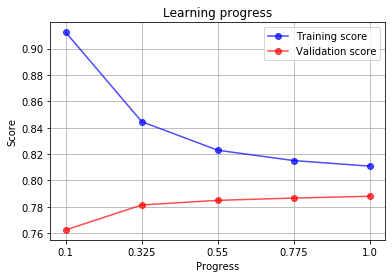

Training CV score: 0.8361
Validation CV score: 0.7833


In [10]:
# Gradient Boosting classifier

# Features and target are defined
y = train_mf.default_ind.values
X = train_mf.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definiton and training
model = GradientBoostingClassifier(n_estimators=200)
model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
auc_score = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
acc_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
bal_acc_score = cross_val_score(model, X, y, cv=5, scoring='balanced_accuracy')
f_score = cross_val_score(model, X, y, cv=5, scoring='f1')
print("ROC-AUC Score (no CV): {}".format(auc_score))
print("Accuracy Score (no CV): {}".format(acc_score))
print("Balanced Accuracy Score (no CV): {}".format(bal_acc_score))
print("F1 Score: {}".format(f_score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
# learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2)

### On SMOTE resampled dataset

**UPDATED: 30th October, 2019**

Performance of XGBoost and LightGBM on SMOTE resampled dataset. The resampling has improved their performance significantly.

ROC-AUC Score (no CV): 0.8409807966515588

              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85     11754
         1.0       0.89      0.78      0.83     11753

    accuracy                           0.84     23507
   macro avg       0.85      0.84      0.84     23507
weighted avg       0.85      0.84      0.84     23507



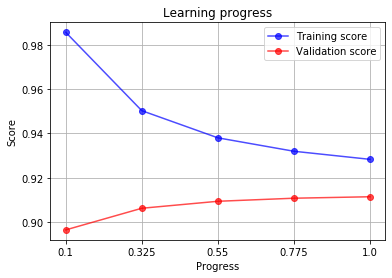

Training CV score: 0.9475
Validation CV score: 0.9054


In [23]:
# XGBoost Classifier

# Features and target are defined
y = train_mf_res.default_ind.values
X = train_mf_res.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definiton and training
model = XGBClassifier(n_estimators=300,
                      max_depth=5,
                      learning_rate=0.05,
                      objective='binary:logistic',
                      random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2)

ROC-AUC Score (no CV): 0.8414912249803579

              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85     11754
         1.0       0.89      0.78      0.83     11753

    accuracy                           0.84     23507
   macro avg       0.85      0.84      0.84     23507
weighted avg       0.85      0.84      0.84     23507



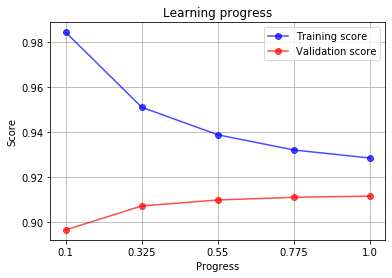

Training CV score: 0.9478
Validation CV score: 0.9058


In [24]:
# LightGBM Classifier

# Features and target are defined
y = train_mf_res.default_ind.values
X = train_mf_res.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = LGBMClassifier(n_estimators=300,
                       max_depth=5,
                       learning_rate=0.05, 
                       objective='binary',
                       random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2) 

ROC-AUC Score (no CV): 0.8399598567479525

              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85     11754
         1.0       0.89      0.78      0.83     11753

    accuracy                           0.84     23507
   macro avg       0.85      0.84      0.84     23507
weighted avg       0.85      0.84      0.84     23507



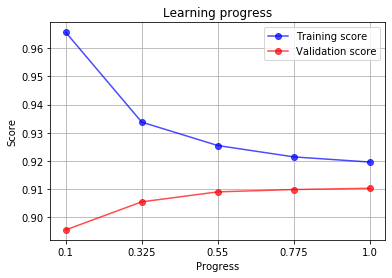

Training CV score: 0.9337
Validation CV score: 0.9045


In [28]:
# Gradient Boosting classifier

# Features and target are defined
y = train_mf_res.default_ind.values
X = train_mf_res.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definiton and training
model = GradientBoostingClassifier(n_estimators=300)
model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2)

## ANN with Entity Embeddings

**UPDATED: 30th October, 2019**

Neural networks are famous for being able to generate non-linear relations between features on their own, thus mitigating the need for feature engineering. However, they can only find such relations with continuous data and are unable to deal with categorical variables. To work around this difficulty, the idea of **Entity Embeddings** was drawn from the field of Natural Language Processing (corresponding concept being **word embeddings**). Using this transformation, a categorical variable is projected into a multi-dimensional space; categorical values resulting in the same target output are clustered together. **We are using the resampled, miss forest imputed dataset here.**

Please check out the original work by Prof Yoshua Bengio et al [here](https://www.aaai.org/ocs/index.php/AAAI/AAAI11/paper/view/3659/3898) and [here](https://arxiv.org/pdf/1604.06737.pdf).

In [21]:
# Dependencies

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.layers.embeddings import Embedding

# Load data
train_mf = pd.read_csv("/home/nishant/Desktop/IDA Project/mod_data/train_mf_res.csv")


# EMBEDDING FOR LOCATION ID ================================================================================

labels = train_mf.default_ind.values

le = LabelEncoder()
train_mf['location_id'] = le.fit_transform(train_mf.location_id)

vocab_size = train_mf.location_id.nunique()
max_length = 1
embed_vec_size = 36
loc_id = train_mf.location_id.values

# Define model
print('[INFO] Generating embeddings')
model = Sequential()
model.add(Embedding(vocab_size, embed_vec_size, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(loc_id, labels, epochs=1, batch_size=100)

# Get outputs of first layer
new_model = Sequential()
new_model.add(Embedding(vocab_size, embed_vec_size, input_length=max_length))

new_model.set_weights(model.layers[0].get_weights())
new_model.compile(optimizer='adam', loss='binary_crossentropy')

preds = new_model.predict(loc_id).reshape(-1, embed_vec_size)
embed_cols = ['loc_emb'+str(i) for i in range(preds.shape[1])]
loc_embed_df = pd.DataFrame(preds, columns=embed_cols)

# =============================================================================================================

# Scaling numerical columns of X
ss = StandardScaler()
non_num_cols = ['application_key', 'card_type', 'location_id', 'default_ind']
X_sc = ss.fit_transform(train_mf.drop(non_num_cols, axis=1).values)

X_df = pd.DataFrame(X_sc)
X_df['card_type'] = train_mf.card_type.values
X_df = pd.concat([X_df, loc_embed_df], axis=1)

y = to_categorical(train_mf.default_ind.values)
X = X_df.values

rows, cols = X.shape[0], X.shape[1]

# Defining prediction model
print('')
print('[INFO] Training model')
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=cols))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.fit(X, y, epochs=100, batch_size=1000)

# Predictions
preds = []
probs = model.predict(X_val)
for i in probs:
    preds.append(np.argmax(i))

y_val_preds = []
for i in y_val:
    y_val_preds.append(np.argmax(i))

preds = np.array(preds).reshape((-1, 1))
y_val_preds = np.array(y_val_preds).reshape((-1, 1))

score = roc_auc_score(y_val_preds, preds)
print('')
print("AUC Score: {:.4f}".format(score))
print('')
print(classification_report(y_val_preds, preds))

[INFO] Generating embeddings
Epoch 1/1
117534/117534 [==============================] - 3s 26us/step - loss: 0.6041 - binary_accuracy: 0.6678

[INFO] Training model
Epoch 1/100
117534/117534 [==============================] - 1s 8us/step - loss: 0.4809 - binary_accuracy: 0.7621
Epoch 2/100
117534/117534 [==============================] - 1s 6us/step - loss: 0.4389 - binary_accuracy: 0.7849
Epoch 3/100
117534/117534 [==============================] - 1s 6us/step - loss: 0.4331 - binary_accuracy: 0.7895
Epoch 4/100
117534/117534 [==============================] - 1s 6us/step - loss: 0.4308 - binary_accuracy: 0.7907
Epoch 5/100
117534/117534 [==============================] - 1s 8us/step - loss: 0.4274 - binary_accuracy: 0.7928
Epoch 6/100
117534/117534 [==============================] - 1s 6us/step - loss: 0.4243 - binary_accuracy: 0.7944
Epoch 7/100
117534/117534 [==============================] - 1s 6us/step - loss: 0.4213 - binary_accuracy: 0.7968
Epoch 8/100
117534/117534 [==========

### On dataset with magic UID

**UPDATED: 31st October, 2019**

In the attempt below, we see the performance of XGBoost and LightGBM on dataset containing the magic UID defined in the EDA notebook.

ROC-AUC Score (no CV): 0.833563756248006

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      9403
           1       0.88      0.78      0.82      9403

    accuracy                           0.83     18806
   macro avg       0.84      0.83      0.83     18806
weighted avg       0.84      0.83      0.83     18806



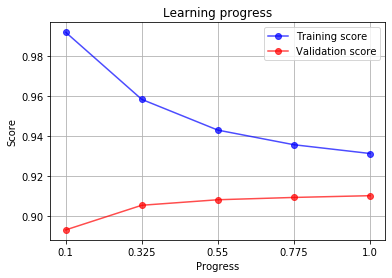

Training CV score: 0.9521
Validation CV score: 0.9059


In [5]:
# XGBoost Classifier

# Features and target are defined
y = train_final.default_ind.values
X = train_final.drop(['application_key', 'default_ind', 'magic_uid'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definiton and training
model = XGBClassifier(n_estimators=300,
                      max_depth=5,
                      learning_rate=0.05,
                      objective='binary:logistic',
                      random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2)

# Precision and recall
precision, recall, f_score, _ = precision_recall_fscore_support(y_val, preds, average='weighted')

In [6]:
print("Precision: {:.4f}".format(precision))
print("Recall {:.4f}".format(recall))
print("F-score {:.4f}".format(f_score))

# Test set performance
y_ = test_final.default_ind.values
X_ = test_final.drop(['application_key', 'default_ind', 'magic_uid'], axis=1).values

preds = model.predict(X_)
score = roc_auc_score(y_, preds)
print("Test ROC-AUC score: {:.4f}".format(score))

Precision: 0.8380
Recall 0.8336
F-score 0.8330
Test ROC-AUC score: 0.8395


ROC-AUC Score (no CV): 0.840810583900387

              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85     11754
         1.0       0.89      0.78      0.83     11753

    accuracy                           0.84     23507
   macro avg       0.85      0.84      0.84     23507
weighted avg       0.85      0.84      0.84     23507



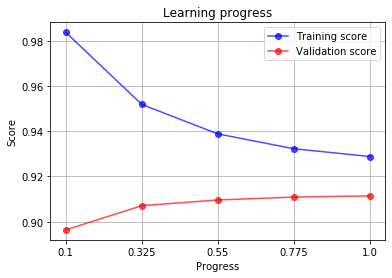

Training CV score: 0.9480
Validation CV score: 0.9058


In [6]:
# LightGBM Classifier

# Features and target are defined
y = train_mf_res.default_ind.values
X = train_mf_res.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = LGBMClassifier(n_estimators=300,
                       max_depth=5,
                       learning_rate=0.05, 
                       objective='binary',
                       metric='auc',
                       random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2) 

The `magic_uid` has pushed up the performance slightly, but no significant development has happened.

In [7]:
# Dense nueral network with entity embedding for lot of columns

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.layers.embeddings import Embedding

# Load data
train_mf = pd.read_csv("/home/nishant/Desktop/IDA Project/mod_data/train_mf_res.csv")

# Scaling numerical columns of X
ss = StandardScaler()
drop_cols = ['application_key', 'card_type', 'location_id', 'magic_uid', 'default_ind', 
             'lines_act', 'lines_act_2yrs', 'lines_high_risk', 'cards_act_t2',
             'pc_lines_act', 'pc_cards_act', 'lines_act_1_miss', 'fc_lines_act', 'fc_cards_act',
             'fc_cards_act_rev', 'auto_2_miss']
X_sc = ss.fit_transform(train_mf.drop(drop_cols, axis=1).values)
X_df = pd.DataFrame(X_sc)
X_df['card_type'] = train_mf.card_type.values


# EMBEDDING FOR CHOSEN COLUMNS ================================================================================

labels = train_mf.default_ind.values

le = LabelEncoder()
embed_cols = ['location_id', 'magic_uid', 'lines_act', 'lines_act_2yrs', 'lines_high_risk', 'cards_act_t2',
              'pc_lines_act', 'pc_cards_act', 'lines_act_1_miss', 'fc_lines_act', 'fc_cards_act',
              'fc_cards_act_rev', 'auto_2_miss']

for col in embed_cols:
    
    train_mf[col] = le.fit_transform(train_mf[col])
    vocab_size = train_mf[col].nunique()
    max_length = 1
    embed_vec_size = 50
    col_vals = train_mf[col].values

    # Define model
    print('\n[INFO] Generating embeddings for '+col)
    model = Sequential()
    model.add(Embedding(vocab_size, embed_vec_size, input_length=max_length))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    model.fit(col_vals, labels, epochs=1, batch_size=100)

    # Get outputs of first layer
    new_model = Sequential()
    new_model.add(Embedding(vocab_size, embed_vec_size, input_length=max_length))

    new_model.set_weights(model.layers[0].get_weights())
    new_model.compile(optimizer='adam', loss='binary_crossentropy')

    preds = new_model.predict(col_vals).reshape(-1, embed_vec_size)
    embed_cols = [col+'_emb'+str(i) for i in range(preds.shape[1])]
    col_embed_df = pd.DataFrame(preds, columns=embed_cols)

    X_df = pd.concat([X_df, col_embed_df], axis=1)

# =============================================================================================================


y = to_categorical(train_mf.default_ind.values)
X = X_df.values

rows, cols = X.shape[0], X.shape[1]

# Defining prediction model
print('')
print('[INFO] Training model')
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=cols))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.fit(X, y, epochs=5, batch_size=100)

# Predictions
preds = []
probs = model.predict(X_val)
for i in probs:
    preds.append(np.argmax(i))

y_val_preds = []
for i in y_val:
    y_val_preds.append(np.argmax(i))

preds = np.array(preds).reshape((-1, 1))
y_val_preds = np.array(y_val_preds).reshape((-1, 1))

score = roc_auc_score(y_val_preds, preds)
print('')
print("AUC Score: {:.4f}".format(score))
print('')
print(classification_report(y_val_preds, preds))


[INFO] Generating embeddings for location_id
Epoch 1/1
117534/117534 [==============================] - 3s 28us/step - loss: 0.6013 - binary_accuracy: 0.6691

[INFO] Generating embeddings for magic_uid
Epoch 1/1
117534/117534 [==============================] - 1s 10us/step - loss: 0.6523 - binary_accuracy: 0.6246

[INFO] Generating embeddings for lines_act
Epoch 1/1
117534/117534 [==============================] - 30s 259us/step - loss: 0.5810 - binary_accuracy: 0.7565

[INFO] Generating embeddings for lines_act_2yrs
Epoch 1/1
117534/117534 [==============================] - 29s 247us/step - loss: 0.5814 - binary_accuracy: 0.7585

[INFO] Generating embeddings for lines_high_risk
Epoch 1/1
117534/117534 [==============================] - 26s 223us/step - loss: 0.5662 - binary_accuracy: 0.7697

[INFO] Generating embeddings for cards_act_t2
Epoch 1/1
117534/117534 [==============================] - 25s 212us/step - loss: 0.5763 - binary_accuracy: 0.7465

[INFO] Generating embeddings for 

### On dataset with weight of evidence for location ID 
Here we test the performance of our model on the data with weight of evidence for `location_id` added. This may not work on the real test dataset if it contains location IDs not present in the dataset. However, since our missing forest imputation generated many new location IDs, the chances of us not having a location ID is low. 

ROC-AUC Score (no CV): 0.8391939102258542

              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85     11754
         1.0       0.89      0.77      0.83     11753

    accuracy                           0.84     23507
   macro avg       0.85      0.84      0.84     23507
weighted avg       0.85      0.84      0.84     23507



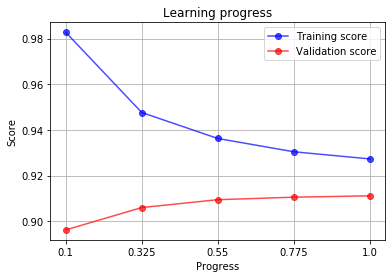

Training CV score: 0.9457
Validation CV score: 0.9059


In [5]:
# LightGBM Classifier

# Features and target are defined
y = train_mf_res.default_ind.values
X = train_mf_res.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = LGBMClassifier(n_estimators=300,
                       max_depth=5,
                       learning_rate=0.05, 
                       objective='binary',
                       metric='auc',
                       random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2) 

## Neural Network test on modified data
Here we test the performance of our entity embedding based neural network on the modified dataset `train_final.csv` and `test_final.csv`.

In [5]:
# Get data in required form

train_mf = pd.read_csv(".././mod_data/train_final.csv")
test_mf = pd.read_csv(".././mod_data/test_final.csv")

In [19]:
# Dependencies

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.layers.embeddings import Embedding

y = to_categorical(train_mf.default_ind.values)
X = train_mf.drop('default_ind', axis=1).values

rows, cols = X.shape[0], X.shape[1]

# Defining prediction model
print('')
print('[INFO] Training model')
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=cols))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.fit(X, y, epochs=1, batch_size=10)

# Testing data
y_val = test_mf.default_ind.values
X_val = test_mf.drop('default_ind', axis=1).values

# Predictions
preds = []
probs = model.predict(X_val)
for i in probs:
    preds.append(np.argmax(i))

preds = np.array(preds).reshape((-1, 1))
y_val_preds = np.array(y_val).reshape((-1, 1))

score = roc_auc_score(y_val_preds, preds)
print('')
print("AUC Score: {:.4f}".format(score))
print('')
print(classification_report(y_val_preds, preds))


[INFO] Training model
Epoch 1/1
94262/94262 [==============================] - 14s 152us/step - loss: 0.5646 - binary_accuracy: 0.7133

AUC Score: 0.7076

              precision    recall  f1-score   support

           0       0.84      0.75      0.80     11636
           1       0.53      0.66      0.59      4857

    accuracy                           0.73     16493
   macro avg       0.69      0.71      0.69     16493
weighted avg       0.75      0.73      0.73     16493



ROC-AUC Score (no CV): 0.6910511105765137

              precision    recall  f1-score   support

           0       0.83      0.74      0.79     11636
           1       0.51      0.64      0.57      4857

    accuracy                           0.71     16493
   macro avg       0.67      0.69      0.68     16493
weighted avg       0.74      0.71      0.72     16493



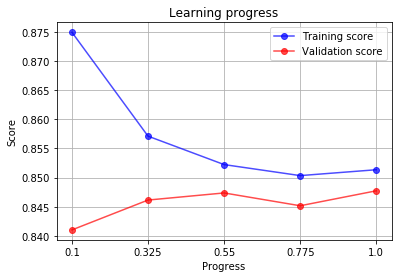

Training CV score: 0.8547
Validation CV score: 0.8453


In [21]:
# How does LightGBM perform?

# Features and target are defined
y_train = train_mf.default_ind.values
X_train = train_mf.drop(['default_ind'], axis=1).values

# Load testing data
y_val = test_mf.default_ind.values
X_val = test_mf.drop('default_ind', axis=1).values

# Model definition and training
model = LGBMClassifier(n_estimators=50,
                       max_depth=3,
                       learning_rate=0.05, 
                       objective='binary',
                       metric='auc',
                       random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X_train, y_train, res=5, scoring='roc_auc', cv=2) error

## On randomly over-sampled data
Let's see if this works out.

ROC-AUC Score (no CV): 0.739722442215

              precision    recall  f1-score   support

         0.0       0.73      0.75      0.74      9427
         1.0       0.75      0.73      0.74      9426

   micro avg       0.74      0.74      0.74     18853
   macro avg       0.74      0.74      0.74     18853
weighted avg       0.74      0.74      0.74     18853



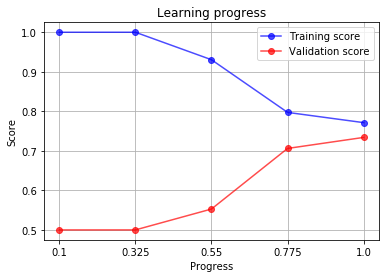

Training CV score: 0.7714
Validation CV score: 0.7340

Performance on testing data:

ROC-AUC Score: 0.7066
Accuracy Score: 0.7296

              precision    recall  f1-score   support

         0.0       0.84      0.76      0.80     11636
         1.0       0.53      0.65      0.59      4857

   micro avg       0.73      0.73      0.73     16493
   macro avg       0.69      0.71      0.69     16493
weighted avg       0.75      0.73      0.74     16493



In [51]:
# LightGBM Classifier

# Features and target are defined
y = train_os.default_ind.values
X = train_os.drop(['default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = LGBMClassifier(n_estimators=300,
                       max_depth=5,
                       learning_rate=0.05, 
                       objective='binary',
                       metric='auc',
                       random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)
preds_train_lgb = model.predict(X)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

# Testing data performance
print("====================================================================")
print('')
print("Performance on testing data:")
print('')

y_test = test_rs.default_ind.values
X_test = test_rs.drop('default_ind', axis=1).values

test_preds_lgb = model.predict(X_test)
auc_score = roc_auc_score(y_test, test_preds_lgb)
acc_score = accuracy_score(y_test, test_preds_lgb)

print("ROC-AUC Score: {:.4f}".format(auc_score))
print("Accuracy Score: {:.4f}".format(acc_score))
print('')
print(classification_report(y_test, test_preds_lgb))

ROC-AUC Score (no CV): 0.738820872443

              precision    recall  f1-score   support

         0.0       0.73      0.75      0.74      9427
         1.0       0.74      0.73      0.74      9426

   micro avg       0.74      0.74      0.74     18853
   macro avg       0.74      0.74      0.74     18853
weighted avg       0.74      0.74      0.74     18853



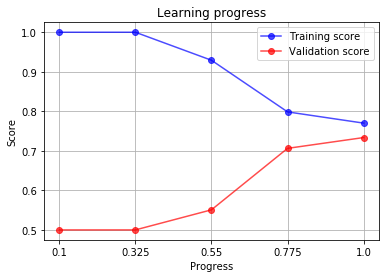

Training CV score: 0.7701
Validation CV score: 0.7336

Performance on testing data:

ROC-AUC Score: 0.7072
Accuracy Score: 0.7290

              precision    recall  f1-score   support

         0.0       0.84      0.76      0.80     11636
         1.0       0.53      0.65      0.59      4857

   micro avg       0.73      0.73      0.73     16493
   macro avg       0.69      0.71      0.69     16493
weighted avg       0.75      0.73      0.74     16493



In [52]:
# XGBoost Classifier

# Features and target are defined
y = train_os.default_ind.values
X = train_os.drop(['default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = XGBClassifier(n_estimators=300,
                       max_depth=5,
                       learning_rate=0.05, 
                       objective='binary:logistic',
                       metric='auc',
                       random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)
train_preds_xgb = model.predict(X)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

# Testing data performance
print("====================================================================")
print('')
print("Performance on testing data:")
print('')

y_test = test_rs.default_ind.values
X_test = test_rs.drop('default_ind', axis=1).values

test_preds_xgb = model.predict(X_test)
auc_score = roc_auc_score(y_test, test_preds_xgb)
acc_score = accuracy_score(y_test, test_preds_xgb)

print("ROC-AUC Score: {:.4f}".format(auc_score))
print("Accuracy Score: {:.4f}".format(acc_score))
print('')
print(classification_report(y_test, test_preds_xgb))

In [26]:
# Neural network

# Dependencies

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.utils import to_categorical
from keras.layers.embeddings import Embedding

# EMBEDDING FOR TRAIN LOCATION ID ============================================================================

labels = train_us.default_ind.values

le = LabelEncoder()
train_us['location_id'] = le.fit_transform(train_us.location_id)
test_rs['location_id'] = le.fit_transform(test_rs.location_id)

vocab_size = train.location_id.nunique()
max_length = 1
embed_vec_size = 33
loc_id_train = train_us.location_id.values
loc_id_test = test_rs.location_id.values

# Define model
print('[INFO] Generating embeddings')
model = Sequential()
model.add(Embedding(vocab_size, embed_vec_size, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(loc_id_train, labels, epochs=5, batch_size=100)

# Get outputs of first layer
new_model = Sequential()
new_model.add(Embedding(vocab_size, embed_vec_size, input_length=max_length))

new_model.set_weights(model.layers[0].get_weights())
new_model.compile(optimizer='adam', loss='binary_crossentropy')

preds_train = new_model.predict(loc_id_train).reshape(-1, embed_vec_size)
preds_test = new_model.predict(loc_id_test).reshape(-1, embed_vec_size)
embed_col_train = ['loc_emb'+str(i) for i in range(preds_train.shape[1])]
embed_col_test = ['loc_emb'+str(i) for i in range(preds_test.shape[1])]
loc_embed_df_train = pd.DataFrame(preds_train, columns=embed_col_train)
loc_embed_df_test = pd.DataFrame(preds_test, columns=embed_col_test)

# =============================================================================================================

# Scaling numerical columns of X
ss = StandardScaler()
non_num_cols = ['card_type', 'location_id', 'default_ind']
X_sc_train = ss.fit_transform(train_us.drop(non_num_cols, axis=1).values)
X_sc_test = ss.fit_transform(test_rs.drop(non_num_cols, axis=1).values)

X_df_train = pd.DataFrame(X_sc_train)
X_df_train['card_type'] = train_us.card_type.values
X_df_train = pd.concat([X_df_train, loc_embed_df_train], axis=1)

X_df_test = pd.DataFrame(X_sc_test)
X_df_test['card_type'] = test_rs.card_type.values
X_df_test = pd.concat([X_df_test, loc_embed_df_test], axis=1)

# Training data
y = to_categorical(train_us.default_ind.values)
X = X_df_train.values

rows, cols = X.shape[0], X.shape[1]

# Defining prediction model
print('')
print('[INFO] Training model')
model = Sequential()
model.add(Dense(128, input_dim=cols))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.25))
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.25))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X, y, epochs=1, batch_size=1000)

y_val = test_rs.default_ind.values
X_val = X_df_test.values

# Predictions
preds = []
probs = model.predict(X_val)
for i in probs:
    preds.append(np.argmax(i))

preds = np.array(preds).reshape((-1, 1))
y_val_preds = np.array(y_val).reshape((-1, 1))

auc_score = roc_auc_score(y_val_preds, preds)
acc_score = accuracy_score(y_val_preds, preds)
bal_acc_score = balanced_accuracy_score(y_val_preds, preds)
f_score = f1_score(y_val_preds, preds)
print('')
print("AUC Score: {:.4f}".format(auc_score))
print("Accuracy Score: {:.4f}".format(acc_score))
print("Balanced Accuracy Score: {:.4f}".format(bal_acc_score))
print("F1 Score: {:.4f}".format(f_score))
print('')
print(classification_report(y_val_preds, preds))

[INFO] Generating embeddings
Epoch 1/5
37682/37682 [==============================] - 1s 23us/step - loss: 0.6908 - binary_accuracy: 0.5312
Epoch 2/5
37682/37682 [==============================] - 1s 15us/step - loss: 0.6898 - binary_accuracy: 0.5368
Epoch 3/5
37682/37682 [==============================] - 1s 15us/step - loss: 0.6897 - binary_accuracy: 0.5345
Epoch 4/5
37682/37682 [==============================] - 1s 16us/step - loss: 0.6896 - binary_accuracy: 0.5355
Epoch 5/5
37682/37682 [==============================] - 1s 15us/step - loss: 0.6896 - binary_accuracy: 0.5347

[INFO] Training model
Epoch 1/1
37682/37682 [==============================] - 2s 60us/step - loss: 0.6063 - accuracy: 0.6815

AUC Score: 0.6999
Accuracy Score: 0.6629
Balanced Accuracy Score: 0.6999
F1 Score: 0.5798

              precision    recall  f1-score   support

         0.0       0.87      0.61      0.72     11636
         1.0       0.46      0.79      0.58      4857

   micro avg       0.66      0.66

ROC-AUC Score (no CV): 0.706416865246

              precision    recall  f1-score   support

         0.0       0.74      0.63      0.68      9427
         1.0       0.68      0.78      0.73      9426

   micro avg       0.71      0.71      0.71     18853
   macro avg       0.71      0.71      0.70     18853
weighted avg       0.71      0.71      0.70     18853



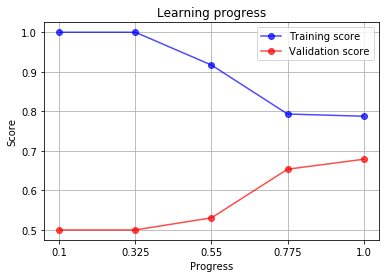

Training CV score: 0.7876
Validation CV score: 0.6787

Performance on testing data:

ROC-AUC Score: 0.6166
Accuracy Score: 0.6236

              precision    recall  f1-score   support

         0.0       0.79      0.63      0.70     11636
         1.0       0.41      0.60      0.48      4857

   micro avg       0.62      0.62      0.62     16493
   macro avg       0.60      0.62      0.59     16493
weighted avg       0.68      0.62      0.64     16493



In [53]:
# K-Neighbors Classifier

# Features and target are defined
y = train_os.default_ind.values
X = train_os.drop(['default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)
train_preds_knn = model.predict(X)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

# Testing data performance
print("====================================================================")
print('')
print("Performance on testing data:")
print('')

y_test = test_rs.default_ind.values
X_test = test_rs.drop('default_ind', axis=1).values

test_preds_knn = model.predict(X_test)
auc_score = roc_auc_score(y_test, test_preds_knn)
acc_score = accuracy_score(y_test, test_preds_knn)

print("ROC-AUC Score: {:.4f}".format(auc_score))
print("Accuracy Score: {:.4f}".format(acc_score))
print('')
print(classification_report(y_test, test_preds_knn))

In [54]:
# Logistic Regression

# Features and target are defined
y = train_os.default_ind.values
X = train_os.drop(['default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = LogisticRegression()
model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)
train_preds_lr = model.predict(X)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
# learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

# Testing data performance
print("====================================================================")
print('')
print("Performance on testing data:")
print('')

y_test = test_rs.default_ind.values
X_test = test_rs.drop('default_ind', axis=1).values

test_preds_lr = model.predict(X_test)
auc_score = roc_auc_score(y_test, test_preds_lr)
acc_score = accuracy_score(y_test, test_preds_lr)

print("ROC-AUC Score: {:.4f}".format(auc_score))
print("Accuracy Score: {:.4f}".format(acc_score))
print('')
print(classification_report(y_test, test_preds_lr))

ROC-AUC Score (no CV): 0.66748200985

              precision    recall  f1-score   support

         0.0       0.68      0.63      0.65      9427
         1.0       0.66      0.71      0.68      9426

   micro avg       0.67      0.67      0.67     18853
   macro avg       0.67      0.67      0.67     18853
weighted avg       0.67      0.67      0.67     18853


Performance on testing data:

ROC-AUC Score: 0.6704
Accuracy Score: 0.6591

              precision    recall  f1-score   support

         0.0       0.84      0.64      0.73     11636
         1.0       0.45      0.70      0.55      4857

   micro avg       0.66      0.66      0.66     16493
   macro avg       0.64      0.67      0.64     16493
weighted avg       0.72      0.66      0.67     16493



In [88]:
# CatBoost Classifier

# Features and target are defined
y = train_os.default_ind
X = train_os.drop(['default_ind'], axis=1)
cat_idx = np.array([c for c, col in enumerate(train_os.columns) if col in ['card_type', 'location_id']])

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = CatBoostClassifier(iterations=300,
                           depth=5,
                           learning_rate=0.05, 
                           eval_metric='Accuracy',
                           cat_features=cat_idx,
                           random_seed=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)
train_preds_cat = model.predict(X)

# Scoring
score = roc_auc_score(y_val, preds)
print("\nROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
# learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

# Testing data performance
print("====================================================================")
print('')
print("Performance on testing data:")
print('')

y_test = test_rs.default_ind
X_test = test_rs.drop('default_ind', axis=1)

test_preds_cat = model.predict(X_test)
auc_score = roc_auc_score(y_test, test_preds_cat)
acc_score = accuracy_score(y_test, test_preds_cat)

print("ROC-AUC Score: {:.4f}".format(auc_score))
print("Accuracy Score: {:.4f}".format(acc_score))
print('')
print(classification_report(y_test, test_preds_cat))

0:	learn: 0.6948773	total: 36.7ms	remaining: 11s
1:	learn: 0.6945457	total: 68.8ms	remaining: 10.2s
2:	learn: 0.6968266	total: 98.2ms	remaining: 9.72s
3:	learn: 0.6980467	total: 133ms	remaining: 9.81s
4:	learn: 0.6982323	total: 162ms	remaining: 9.55s
5:	learn: 0.6981660	total: 193ms	remaining: 9.44s
6:	learn: 0.6988291	total: 223ms	remaining: 9.34s
7:	learn: 0.6998634	total: 273ms	remaining: 9.98s
8:	learn: 0.7005132	total: 319ms	remaining: 10.3s
9:	learn: 0.7003939	total: 357ms	remaining: 10.4s
10:	learn: 0.7008182	total: 391ms	remaining: 10.3s
11:	learn: 0.7007254	total: 424ms	remaining: 10.2s
12:	learn: 0.7019984	total: 460ms	remaining: 10.2s
13:	learn: 0.7030858	total: 505ms	remaining: 10.3s
14:	learn: 0.7036693	total: 542ms	remaining: 10.3s
15:	learn: 0.7038285	total: 573ms	remaining: 10.2s
16:	learn: 0.7036693	total: 607ms	remaining: 10.1s
17:	learn: 0.7040274	total: 650ms	remaining: 10.2s
18:	learn: 0.7047965	total: 731ms	remaining: 10.8s
19:	learn: 0.7054728	total: 826ms	remain

In [27]:
# Random Forest Classifier

# Features and target are defined
y = train_os.default_ind.values
X = train_os.drop(['default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = RandomForestClassifier(n_estimators=300, random_state=123)
model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)
train_preds_rf = model.predict(X)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
# learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

# Testing data performance
print("====================================================================")
print('')
print("Performance on testing data:")
print('')

y_test = test_rs.default_ind.values
X_test = test_rs.drop('default_ind', axis=1).values

test_preds_rf = model.predict(X_test)
auc_score = roc_auc_score(y_test, test_preds_rf)
acc_score = accuracy_score(y_test, test_preds_rf)
bal_acc_score = balanced_accuracy_score(y_test, test_preds_rf)
f_score = f1_score(y_test, test_preds_rf)

print("ROC-AUC Score: {:.4f}".format(auc_score))
print("Accuracy Score: {:.4f}".format(acc_score))
print("Balanced Accuracy Score {:.4f}".format(bal_acc_score))
print("F1 Score: {:.4f}".format(f_score))
print('')
print(classification_report(y_test, test_preds_rf))

ROC-AUC Score (no CV): 0.902934514091

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      9427
         1.0       0.88      0.93      0.91      9426

   micro avg       0.90      0.90      0.90     18853
   macro avg       0.90      0.90      0.90     18853
weighted avg       0.90      0.90      0.90     18853


Performance on testing data:

ROC-AUC Score: 0.6819
Accuracy Score: 0.7608
Balanced Accuracy Score 0.6819
F1 Score: 0.5468

              precision    recall  f1-score   support

         0.0       0.80      0.87      0.84     11636
         1.0       0.62      0.49      0.55      4857

   micro avg       0.76      0.76      0.76     16493
   macro avg       0.71      0.68      0.69     16493
weighted avg       0.75      0.76      0.75     16493



In [97]:
# Gradient Boosting Classifier

# Features and target are defined
y = train_os.default_ind.values
X = train_os.drop(['default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = GradientBoostingClassifier(n_estimators=300, random_state=123)
model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)
train_preds_gb = model.predict(X)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
# learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

# Testing data performance
print("====================================================================")
print('')
print("Performance on testing data:")
print('')

y_test = test_rs.default_ind.values
X_test = test_rs.drop('default_ind', axis=1).values

test_preds_gb = model.predict(X_test)
auc_score = roc_auc_score(y_test, test_preds_gb)
acc_score = accuracy_score(y_test, test_preds_gb)

print("ROC-AUC Score: {:.4f}".format(auc_score))
print("Accuracy Score: {:.4f}".format(acc_score))
print('')
print(classification_report(y_test, test_preds_gb))

ROC-AUC Score (no CV): 0.73081153985

              precision    recall  f1-score   support

         0.0       0.73      0.74      0.73      9427
         1.0       0.74      0.72      0.73      9426

   micro avg       0.73      0.73      0.73     18853
   macro avg       0.73      0.73      0.73     18853
weighted avg       0.73      0.73      0.73     18853


Performance on testing data:

ROC-AUC Score: 0.7093
Accuracy Score: 0.7171

              precision    recall  f1-score   support

         0.0       0.85      0.73      0.78     11636
         1.0       0.51      0.69      0.59      4857

   micro avg       0.72      0.72      0.72     16493
   macro avg       0.68      0.71      0.69     16493
weighted avg       0.75      0.72      0.73     16493



In [96]:
# AdaBoost Classifier

# Features and target are defined
y = train_os.default_ind.values
X = train_os.drop(['default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = AdaBoostClassifier(n_estimators=300, random_state=123)
model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)
train_preds_ada = model.predict(X)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
# learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

# Testing data performance
print("====================================================================")
print('')
print("Performance on testing data:")
print('')

y_test = test_rs.default_ind.values
X_test = test_rs.drop('default_ind', axis=1).values

test_preds_ada = model.predict(X_test)
auc_score = roc_auc_score(y_test, test_preds_ada)
acc_score = accuracy_score(y_test, test_preds_ada)

print("ROC-AUC Score: {:.4f}".format(auc_score))
print("Accuracy Score: {:.4f}".format(acc_score))
print('')
print(classification_report(y_test, test_preds_ada))

ROC-AUC Score (no CV): 0.719937969749

              precision    recall  f1-score   support

         0.0       0.72      0.73      0.72      9427
         1.0       0.72      0.71      0.72      9426

   micro avg       0.72      0.72      0.72     18853
   macro avg       0.72      0.72      0.72     18853
weighted avg       0.72      0.72      0.72     18853


Performance on testing data:

ROC-AUC Score: 0.7086
Accuracy Score: 0.7141

              precision    recall  f1-score   support

         0.0       0.85      0.72      0.78     11636
         1.0       0.51      0.70      0.59      4857

   micro avg       0.71      0.71      0.71     16493
   macro avg       0.68      0.71      0.68     16493
weighted avg       0.75      0.71      0.72     16493



## Stacking Classifier
Here we attempt a raw stacking classifier. We will use predictions from XGBoost, LightGBM, RandomForest, AdaBoost, GBClassifier, KNN, and CatBoost 

In [128]:
# Combine all training predictions

train_preds_X = np.vstack((train_preds_xgb, preds_train_lgb, train_preds_ada, train_preds_gb, train_preds_knn, train_preds_cat)).T
test_preds_X = np.vstack((test_preds_xgb, test_preds_lgb, test_preds_ada, test_preds_gb, test_preds_knn, test_preds_cat)).T

train_preds_y = train_os.default_ind.values.reshape((-1, 1))
test_preds_y = test_rs.default_ind.values.reshape((-1, 1))

In [129]:
# Convert them into dataframe so CatBoost can work on them

stack_train_X = pd.DataFrame(train_preds_X.astype('int'))
stack_train_y = pd.DataFrame(train_preds_y.astype('int'))
stack_test_X = pd.DataFrame(test_preds_X.astype('int'))
stack_test_y = pd.DataFrame(test_preds_y.astype('int'))

In [130]:
# Train CatBoost classifier on these

# Features and target are defined
y = stack_train_y
X = stack_train_X

y_test = stack_test_y
X_test = stack_test_X
spw = y_test[0].value_counts()[0]/y_test[0].value_counts()[1]

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = LGBMClassifier(n_estimators=300,
                       learning_rate=0.05,
                       max_depth=5,
                       scale_pos_weight=spw,
                       objective='binary',
                       metric='accuracy',
                       random_state=123)
model.fit(X_train, y_train)

# Prediction
preds_train = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds_train)
print("\nROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds_train))


# Testing data performance
print("====================================================================")
print('')
print("Performance on testing data:")
print('')

test_preds = model.predict(X_test)
auc_score = roc_auc_score(y_test, test_preds)
acc_score = accuracy_score(y_test, test_preds)

print("ROC-AUC Score: {:.4f}".format(auc_score))
print("Accuracy Score: {:.4f}".format(acc_score))
print('')
print(classification_report(y_test, test_preds))


ROC-AUC Score (no CV): 0.719575957623

              precision    recall  f1-score   support

           0       0.83      0.55      0.66      9427
           1       0.66      0.89      0.76      9426

   micro avg       0.72      0.72      0.72     18853
   macro avg       0.75      0.72      0.71     18853
weighted avg       0.75      0.72      0.71     18853


Performance on testing data:

ROC-AUC Score: 0.6598
Accuracy Score: 0.6214

              precision    recall  f1-score   support

           0       0.85      0.57      0.68     11636
           1       0.42      0.75      0.54      4857

   micro avg       0.62      0.62      0.62     16493
   macro avg       0.63      0.66      0.61     16493
weighted avg       0.72      0.62      0.64     16493



In [158]:
# A manual implementation of voting classifier

preds_vote_train = [1 if sum(i)*100/len(i) >= 50 else 0 for i in stack_train_X.values]
preds_vote_test = [1 if sum(i)*100/len(i) >= 50 else 0 for i in stack_test_X.values]

# Scoring
score = roc_auc_score(stack_train_y[0].values, preds_vote_train)
print("\nROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(stack_train_y[0].values, preds_vote_train))


# Testing data performance
print("====================================================================")
print('')
print("Performance on testing data:")
print('')

auc_score = roc_auc_score(stack_test_y[0].values, preds_vote_test)
acc_score = accuracy_score(stack_test_y[0].values, preds_vote_test)

print("ROC-AUC Score: {:.4f}".format(auc_score))
print("Accuracy Score: {:.4f}".format(acc_score))
print('')
print(classification_report(stack_test_y[0].values, preds_vote_test))


ROC-AUC Score (no CV): 0.747225817403

              precision    recall  f1-score   support

           0       0.75      0.74      0.75     47131
           1       0.75      0.75      0.75     47131

   micro avg       0.75      0.75      0.75     94262
   macro avg       0.75      0.75      0.75     94262
weighted avg       0.75      0.75      0.75     94262


Performance on testing data:

ROC-AUC Score: 0.7120
Accuracy Score: 0.7175

              precision    recall  f1-score   support

           0       0.85      0.73      0.78     11636
           1       0.52      0.70      0.59      4857

   micro avg       0.72      0.72      0.72     16493
   macro avg       0.68      0.71      0.69     16493
weighted avg       0.75      0.72      0.73     16493



## On dataset after pruning with chi-square
Here with check model performance on dataset with high chi-square importance.

ROC-AUC Score (no CV): 0.724235001238

              precision    recall  f1-score   support

         0.0       0.73      0.72      0.72      9427
         1.0       0.72      0.73      0.72      9426

   micro avg       0.72      0.72      0.72     18853
   macro avg       0.72      0.72      0.72     18853
weighted avg       0.72      0.72      0.72     18853



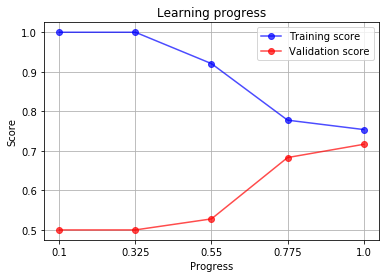

Training CV score: 0.7539
Validation CV score: 0.7165

Performance on testing data:

ROC-AUC Score: 0.6915
Accuracy Score: 0.7020

              precision    recall  f1-score   support

         0.0       0.84      0.72      0.77     11636
         1.0       0.50      0.67      0.57      4857

   micro avg       0.70      0.70      0.70     16493
   macro avg       0.67      0.69      0.67     16493
weighted avg       0.74      0.70      0.71     16493



In [5]:
# LightGBM Classifier

# Features and target are defined
y = train_os_chi2.default_ind.values
X = train_os_chi2.drop(['default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = LGBMClassifier(n_estimators=300,
                       max_depth=5,
                       learning_rate=0.05, 
                       objective='binary',
                       metric='auc',
                       random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)
preds_train_lgb = model.predict(X)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='accuracy', cv=2) 

# Testing data performance
print("====================================================================")
print('')
print("Performance on testing data:")
print('')

y_test = test_rs_chi2.default_ind.values
X_test = test_rs_chi2.drop('default_ind', axis=1).values

test_preds_lgb = model.predict(X_test)
auc_score = roc_auc_score(y_test, test_preds_lgb)
acc_score = accuracy_score(y_test, test_preds_lgb)

print("ROC-AUC Score: {:.4f}".format(auc_score))
print("Accuracy Score: {:.4f}".format(acc_score))
print('')
print(classification_report(y_test, test_preds_lgb))